In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision, Time Series, and Survival Analysis (Lectures 18 to 20)

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

There is a separate time series for each combination of categorical variables `type` and `region`. In this avocado prices dataset, the same date appears many times - once for each region-type pair. This indicates that we're measuring avocado prices separately across regions and types. For example, one time series in this dataset would be how avocadoes of the same region and the same type sorted by the date. If region = "albany" and type = "conventional", then one time series will show how the average avocado price in Albany for conventional avocadoes changed over time. Below, we've sorted the dataframe by region, type and date to observe the structure of the time series, and we can see how there are different measurements for the same region-type pair. Additionally, there are 108 distinct region-type pairs in the dataset. 

In [9]:
#sort by region, type, and date for the time series
df.sort_values(by=["region", "type", "Date"])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
48,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
47,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
3,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
2,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
1,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


In [10]:
#number of unique region-type pairs
df.groupby(["region", "type"]).ngroups

108

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

By using the plot_time_spacing_distribution function from Lecutre 19, I was able to visualize whether the avocado dataset is equally spaced by plotting the time differences between rows for the region-type pair: region = "Albany" and type = "conventional". All 168 time differences were exactly 7 days, shown below in the bar graph. Given this, the subset of the dataset has equally spaced weekly measurements similar to how the Rain in Australia dataset had a typical spacing of 1 day with a few exceptions. Other region-type pairs may still vary in terms of spacing, however, by plotting one pair we are able to confirm that there is equal spacing in this one group. 

In [11]:
#adopted from lecture 19 demo
def plot_time_spacing_distribution_avocados(df, region = "Albany", type_ = "conventional"):
    """
    Plots the distribution of time spacing for a given (region, type) pair in the avocado dataset.

    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Date', 'region', and 'type'.
        region (str): The region to analyze (e.g., "Albany").
        type_ (str): The avocado type to analyze (e.g., "conventional" or "organic").
    """
    # Ensure 'Date' is in datetime format
    df["Date"] = pd.to_datetime(df["Date"])

    # Filter for the specified region and type
    group_data = df[(df["region"] == region) & (df["type"] == type_)]
    
    if group_data.empty:
        print(f"No data available for region={region}, type={type_}")
        return

    # Compute time differences
    time_diffs = group_data["Date"].sort_values().diff().dropna()

    # Count time difference frequencies
    value_counts = time_diffs.value_counts().sort_index()

    # Display result
    print(f"Time spacing counts for region={region}, type={type_}:\n{value_counts}\n")

    # Plot
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region} ({type_})")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for region=Albany, type=conventional:
Date
7 days    168
Name: count, dtype: int64



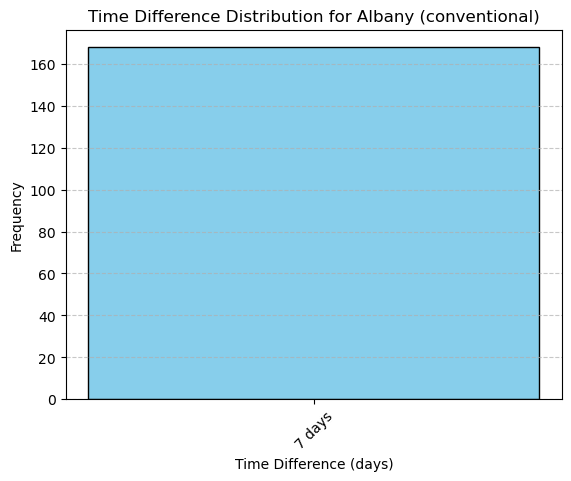

In [12]:
plot_time_spacing_distribution_avocados(df, region = "Albany", type_ = "conventional")

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

After listing all the possible regions in the avocado dataset, we can see that there are region names such as Albany, Atlanta, Boise, Boston, and etc. However, some names represent smaller cities suchas Miami Ft Lauderdale and Dallas Ft Worth, while other regions represent larger or combined areas suchas WestTexNewMexico. There is also a region labeled TotalUS, which aggregates data across all regions. Given these regions, these names are not all distinct, as some may overlap with other regions. Unlike the Rain in Australia dataset where each location was a different place in Australia, the regions in the avocado dataset does include overalpping of areas. 

In [13]:
print(df["region"].unique())

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']


<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures), with some improvements.

In [14]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [15]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [16]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [17]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

Using the baseline approach of assuming there is no change in average price (AveragePriceNextWeek = AveragePrice), the R2 score we obtained on the training data is 0.83, while on the test data, the R2 is 0.76. 

In [18]:
y_train = df_train["AveragePriceNextWeek"]
y_train_pred = df_train["AveragePrice"]

train_r2 = r2_score(y_train, y_train_pred)
print(train_r2)

0.8285800937261841


In [19]:
y_test = df_test["AveragePriceNextWeek"]
y_test_pred = df_test["AveragePrice"]

test_r2 = r2_score(y_test, y_test_pred)
print(test_r2)

0.7631780188583048


In [20]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

To observe the average avocado price next week, I decided to use a Ridge regression model. I added lag features and seasonal encoding based on the Date column, as I believed these features would help with forecasting the average avocado price next week. After feature engineering, I transformed the columns accordingly (scaling the numeric features and encoding the categorical features; no simple imputation was needed as there were no missing values, as seen in .info()). I then computed the scores of the Ridge regression model, and found that the validation score is 0.84, and the training score is 0.85. After computing the test score, the R2 value is 0.85. This relatively high R2 score indicates that the model is able to generalize well, and by encoding season and lag features, I was able to improve the model in comparison to the dummy baseline model (test dummy score = 0.76). 

In [21]:
df_hastarget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18141 entries, 0 to 18247
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  18141 non-null  datetime64[ns]
 1   AveragePrice          18141 non-null  float64       
 2   Total Volume          18141 non-null  float64       
 3   4046                  18141 non-null  float64       
 4   4225                  18141 non-null  float64       
 5   4770                  18141 non-null  float64       
 6   Total Bags            18141 non-null  float64       
 7   Small Bags            18141 non-null  float64       
 8   Large Bags            18141 non-null  float64       
 9   XLarge Bags           18141 non-null  float64       
 10  type                  18141 non-null  object        
 11  year                  18141 non-null  int64         
 12  region                18141 non-null  object        
 13  AveragePriceNextWeek 

In [46]:
#separating Date data
df_hastarget["Date"] = pd.to_datetime(df_hastarget["Date"])
df_hastarget["month"] = df_hastarget["Date"].dt.month

#Feature Engineering - create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df_hastarget["season"] = df_hastarget["month"].apply(get_season)

#Feature Engineering - add a lag feature (previous week's price)
df_hastarget = df_hastarget.sort_values(["region", "type", "Date"])
df_hastarget["AveragePrice_lag"] = df_hastarget.groupby(["region", "type"])["AveragePrice"].shift(1)

##drop the rows with missing values from target or lag
df_hastarget = df_hastarget.dropna(subset=["AveragePriceNextWeek", "AveragePrice_lag"])

In [47]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

In [48]:
X_train = df_train.drop(columns = ["Date", "AveragePriceNextWeek"])
y_train = df_train["AveragePriceNextWeek"]

X_test = df_train.drop(columns = ["Date", "AveragePriceNextWeek"])
y_test = df_train["AveragePriceNextWeek"]

In [49]:
from sklearn.compose import make_column_transformer

#preprocessing
numeric_features = [
    "AveragePrice",
    "AveragePrice_lag",
    "Total Volume",
    "4046", "4225", "4770",
    "Total Bags", "Small Bags", "Large Bags", "XLarge Bags",
    "month", "year"]

categorical_features = [
    "region",
    "type",
    "season"]

target = ["AveragePriceNextWeek"]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown = "ignore", sparse_output = False), categorical_features))

In [53]:
#fit preprocessor, make column names
preprocessor.fit(X_train)

ohe = preprocessor.named_transformers_["onehotencoder"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

new_columns = numeric_features + list(ohe_feature_names)

In [54]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index = X_train.index, columns = new_columns)
X_train_enc

,AveragePrice,AveragePrice_lag,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,...,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,type_conventional,type_organic,season_Fall,season_Spring,season_Summer,season_Winter
2,-0.555945,-0.378750,-0.233490,-0.230908,-0.219499,-0.214022,-0.230323,-0.226900,-0.224865,-0.172973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.824171,-0.550117,-0.233304,-0.230886,-0.218137,-0.213772,-0.231467,-0.229048,-0.222745,-0.172973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.994860,-0.819408,-0.225778,-0.230558,-0.196073,-0.213639,-0.233086,-0.230343,-0.225393,-0.172973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,-0.994860,-0.990775,-0.231517,-0.230556,-0.213270,-0.213780,-0.231705,-0.229035,-0.223795,-0.172973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6,-0.824171,-0.990775,-0.234351,-0.230850,-0.220728,-0.213259,-0.232033,-0.229219,-0.224581,-0.172973,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2.687152,2.534487,-0.241789,-0.229554,-0.242423,-0.215219,-0.232528,-0.229446,-0.225935,-0.172973,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
18219,2.418926,2.705854,-0.244270,-0.230897,-0.242107,-0.215219,-0.240157,-0.239423,-0.225878,-0.172973,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
18220,2.394541,2.436563,-0.243041,-0.230393,-0.241689,-0.215219,-0.236907,-0.235133,-0.226032,-0.172973,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
18221,2.345773,2.412082,-0.243449,-0.230168,-0.243125,-0.215219,-0.236832,-0.235026,-0.226061,-0.172973,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

lr_pipe = make_pipeline(preprocessor, Ridge())
lr_pipe.fit(X_train, y_train)
scores = cross_validate(lr_pipe, X_train, y_train, return_train_score=True) #default score is R2 for regression
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.042081,0.010180,0.832517,0.857623
1,0.027975,0.008492,0.835909,0.855851
2,0.028251,0.008376,0.835895,0.857060
3,0.027613,0.007773,0.879126,0.843825
4,0.029831,0.007567,0.827373,0.856667


In [64]:
scores["train_score"].mean()

0.8542051532205927

<!-- END QUESTION -->

<br><br><br><br>

In [65]:
scores["test_score"].mean() #validation score

0.8421640461651446

In [66]:
#find the R2 for test set
lr_pipe.score(X_test, y_test)

0.8543753829808709

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. A real world situation where time series data would have unequally spaced time points is customer recalls, since they only occur when it is absolutely necessary and does not occur in intervals. A customer could be contatcted at irregular intervals due to different product issues or recalls from the manufacturer.
2. Lag features would struggle with unequally spaced time points, since lag features assume that there is a consistent time interval. However, when we encode the date as many features, it does not depend on specific intervals of time, and is not affected by unequal spacing.
3. Ridge model was unable to capture a periodic pattern because the relationship between time and bike count was not linear, and it is unable to capture the periodic pattern. Instead, we encoded time of day as categories using OneHotEncoder, and this improved R2 scores significantly (from 0.13 to 0.62)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. In a four-class classification problem, LogisticRegression will learn 44 parameters in total. This is computed from 10 coefficients (features) + 1 intercept = 11 * 4 classes = 44
2. This is useful when it came to transfer learning because neural networks apply many transformations in a series to learn general features in early layers, then later learning specific features on later layers. It also requires a large dataset, powerful computers, and lots of effort to train the model by hand. Because of this layered structure, we would then be able to resuse these general layers for new tasks and only retrain the top layers, essentially saving computational cost, saves time, and avoids having to train a deep model from scratch.
3. In a small dataset with 1000 images with names of 50 CS faculty members from UBC, I would use transfer learning with pre-trained CNN. Since the dataset is relatively small, training a CNN from scratch would be computationally expensive. By using Transfer learning, I am able to reuse the general features and leverage the final layers to adapt to the classification task.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2.3 Survival analysis
<hr>

rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? Briefly explain your answer. 
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 6

1. By simply labeling customers as "churned" or "not churned", using standard supervising learning techniques ignores censoring. We do not know when or if customers will churn, but they have not been churned at the time of data collection—labelled as "not churned". By treating these customers as not churned, this may introduce bias because since it assumes that they never will churn.
2. We don't have enough information to answer. By just knowing that A joined last week and B a year ago does not give us information about their behaviour, or risk of churn. We need additional information about an individual's patterns in this case. We can't confidently say who is more likely to leave first.
3. A flat survival function during a certain period indicates that the probability of the customer churning is low during that certain period. The customer is likely to stay subscribed since the risk of churn is stable and minimal. 

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)